<a href="https://colab.research.google.com/github/leonbenenati/Projeto/blob/main/Churn_Modeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Este projeto trata-se de um problema de classificação, onde o objetivo é prever se o cliente vai sair ou não da instituição financeira. Como se trata de classificação a resposta é binário 0 ou 1 
# Há dois cojuntos de dados um onde será realizados todos os procedimentos para chegar no melhor modelo e outro onde será feita a previsão.

# Ajustes iniciais

In [ ]:
#importando bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
#Carrendo os arquivos 
df_treino = pd.read_csv("/content/Abandono_clientes.csv")
df_teste = pd.read_csv("/content/Abandono_teste.csv",sep=";")

In [ ]:
df_treino.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df_teste.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08
1,10002,15588959,T'ang,569,France,Male,34,4,0.00,1,0,1,4045.90
2,10003,15624896,Ku,669,France,Female,20,7,0.00,2,1,0,128838.67
3,10004,15639629,McConnan,694,France,Male,39,4,173255.48,1,1,1,81293.10
4,10005,15638852,Ts'ui,504,Spain,Male,28,10,109291.36,1,1,1,187593.15


In [ ]:
print(df_treino.shape)
print(df_teste.shape)

(10000, 14)
(1000, 13)


# Análise dos dados

In [ ]:
#Verificando se há dados faltantes no conjunto de treino
df_treino.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
#Verificando se há dados faltantes no conjunto de teste
df_teste.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [ ]:
#Principais informações no conjunto de treino
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
#Principais informações no conjunto de teste
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        1000 non-null   int64  
 1   CustomerId       1000 non-null   int64  
 2   Surname          1000 non-null   object 
 3   CreditScore      1000 non-null   int64  
 4   Geography        1000 non-null   object 
 5   Gender           1000 non-null   object 
 6   Age              1000 non-null   int64  
 7   Tenure           1000 non-null   int64  
 8   Balance          1000 non-null   float64
 9   NumOfProducts    1000 non-null   int64  
 10  HasCrCard        1000 non-null   int64  
 11  IsActiveMember   1000 non-null   int64  
 12  EstimatedSalary  1000 non-null   float64
dtypes: float64(2), int64(8), object(3)
memory usage: 101.7+ KB


In [ ]:
#Balanceamento de Exited

df_treino["Exited"].value_counts()/df_treino["Exited"].shape[0]

0   0.80
1   0.20
Name: Exited, dtype: float64

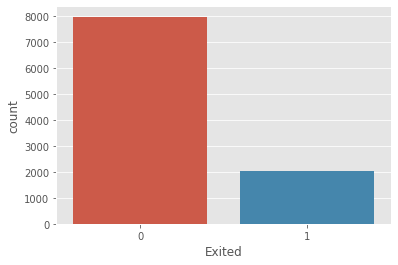

In [ ]:
#Gráfico do Balanceamento de Exited, há um leve desbalanceamento
sns.countplot(x=df_treino["Exited"])

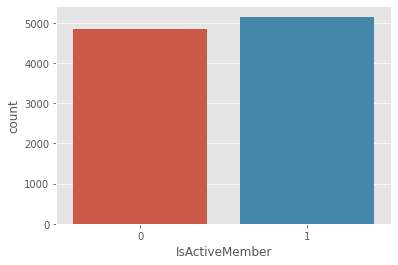

In [ ]:
#na coluna que se trata se o membro é ativo ou não é quase 50/50
sns.countplot(x=df_treino["IsActiveMember"])

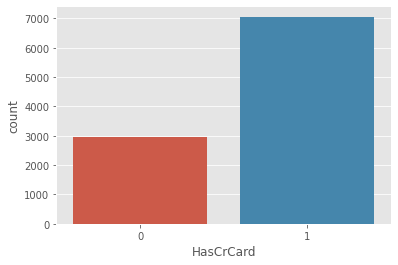

In [ ]:
#Na coluna se o cliente tem cartão de credito, há mais clientes com cartão dos que não tem
sns.countplot(x=df_treino["HasCrCard"])

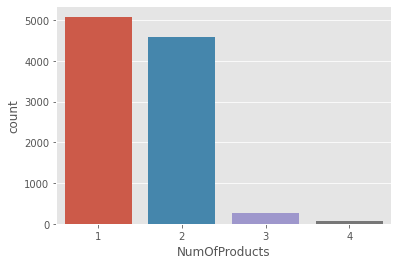

In [ ]:
#Na coluna numero de produtos há bastante 1 e 2 produtos e pouco 3 e 4
sns.countplot(x=df_treino["NumOfProducts"])

In [ ]:
#a porcentagem somada de 3 e 4 produtos somada fica em torno de 3%, enquanto 1 produto tem mais de 50% e 2 produtos tem mais de 45%
df_treino["NumOfProducts"].value_counts()/df_treino["NumOfProducts"].shape[0]

1   0.51
2   0.46
3   0.03
4   0.01
Name: NumOfProducts, dtype: float64

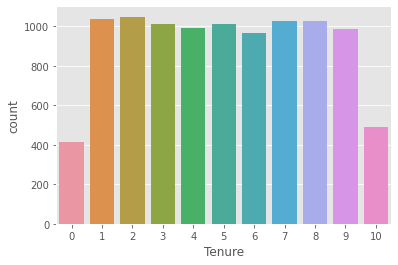

In [ ]:
#Na variável de tempo de empresa do cliente os dados das pontos, 0 e 10, tem em torno de metad
sns.countplot(x=df_treino["Tenure"])

In [ ]:
df_treino["Tenure"].value_counts()/df_treino["Tenure"].shape[0]

2    0.10
1    0.10
7    0.10
8    0.10
5    0.10
3    0.10
4    0.10
9    0.10
6    0.10
10   0.05
0    0.04
Name: Tenure, dtype: float64

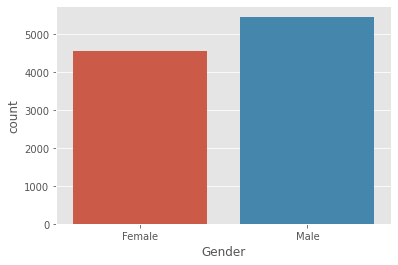

In [ ]:
#Sexo masculino e feminino está equilibrado 
sns.countplot(x=df_treino["Gender"])

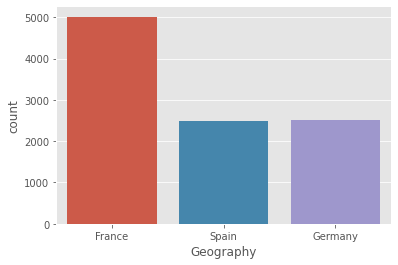

In [ ]:
#França tem em torno de dobro de dados de Espanha e Alemanha
sns.countplot(x=df_treino["Geography"])

Text(0.5, 0, 'EstimatedSalary')

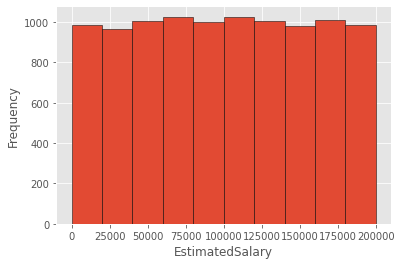

In [ ]:
#A estatística apresenta dados bem uniformes em relação ao salario e q quantidade de frequência que aparece 
df_treino['EstimatedSalary'].plot(kind = 'hist',edgecolor = 'black');
plt.xlabel('EstimatedSalary')

In [ ]:
#A média dos salarios é 100090.23
df_treino["EstimatedSalary"].describe()

count    10000.00
mean    100090.24
std      57510.49
min         11.58
25%      51002.11
50%     100193.91
75%     149388.25
max     199992.48
Name: EstimatedSalary, dtype: float64

Text(0.5, 0, 'Balance')

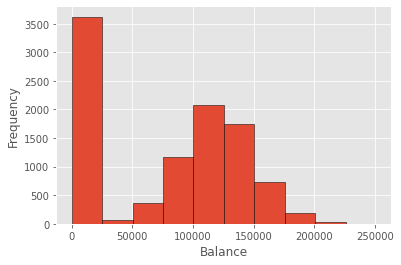

In [ ]:
#No balanço dos clientes há muitos clientes com balanço 0
df_treino['Balance'].plot(kind = 'hist',edgecolor = 'black');
plt.xlabel('Balance')

In [ ]:
#A média da variavel balance é 76485.88 e o minimo é 0
df_treino["Balance"].describe()

count    10000.00
mean     76485.89
std      62397.41
min          0.00
25%          0.00
50%      97198.54
75%     127644.24
max     250898.09
Name: Balance, dtype: float64

Text(0.5, 0, 'CreditScore')

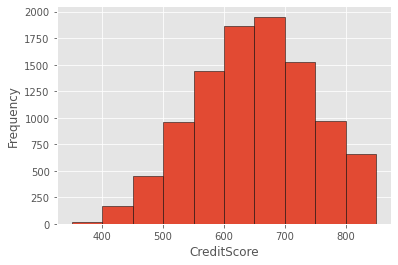

In [ ]:
#A variável de crédito tem a sua média em 650 
df_treino['CreditScore'].plot(kind = 'hist',edgecolor = 'black');
plt.xlabel('CreditScore')

In [ ]:
df_treino["CreditScore"].describe()

count   10000.00
mean      650.53
std        96.65
min       350.00
25%       584.00
50%       652.00
75%       718.00
max       850.00
Name: CreditScore, dtype: float64

Text(0.5, 0, 'Age')

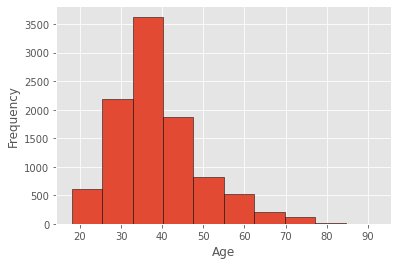

In [ ]:
#A variável de idade tem a sua média em 38
df_treino['Age'].plot(kind = 'hist',edgecolor = 'black');
plt.xlabel('Age')

In [ ]:
df_treino["Age"].describe()

count   10000.00
mean       38.92
std        10.49
min        18.00
25%        32.00
50%        37.00
75%        44.00
max        92.00
Name: Age, dtype: float64

# Pré processamento

In [ ]:
# dropando variaveis sem interesse
df_treino.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)
df_treino

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
#na variavel de produtos como  3 e 4 somam em torno de 3% de clientes, eles serão somados ao número de clientes com  2 produtos, 
#e essa variavel transformada terá número de clientes com 1 produtos e número de clientes que tem mais de 2 produtos
def fun(x):
    if x == 1:
        return 'NumProd1'
    else:
        return 'NumProd2+'

df_treino['NumOfProducts'] = df_treino['NumOfProducts'].apply(fun)

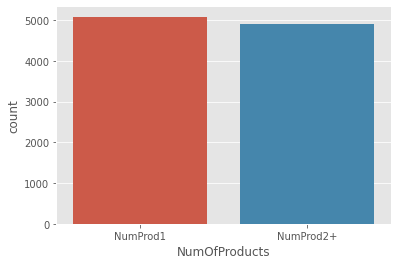

In [ ]:
sns.countplot(x=df_treino["NumOfProducts"])

In [ ]:
#A variável Geography ,Gender, NumOfProducts serão dummificadas 
variaveis = ["Geography", "Gender","NumOfProducts"]

df_treino = pd.get_dummies(df_treino, columns = variaveis, drop_first = True)

df_treino.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_NumProd2+
0,619,42,2,0.00,1,1,101348.88,1,0,0,0,0
1,608,41,1,83807.86,0,1,112542.58,0,0,1,0,0
2,502,42,8,159660.80,1,0,113931.57,1,0,0,0,1
3,699,39,1,0.00,0,0,93826.63,0,0,0,0,1
4,850,43,2,125510.82,1,1,79084.10,0,0,1,0,0


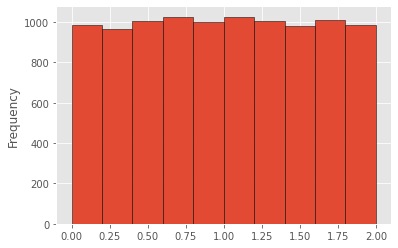

In [ ]:
#A variável EstimatedSalary será divida por 100 mil para ficar na escola de 0 a 2
df_treino['EstimatedSalary'] = df_treino['EstimatedSalary']/100000
df_treino['EstimatedSalary'].plot(kind = 'hist',edgecolor = 'black');

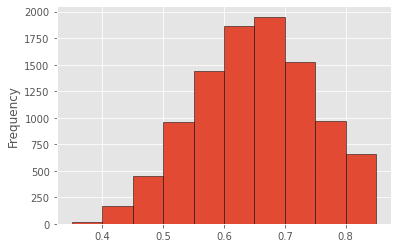

In [ ]:
#A variável CreditScore será divida por 1000 para ficar na escola de 0 a 1
df_treino['CreditScore'] = df_treino['CreditScore']/1000
df_treino['CreditScore'].plot(kind = 'hist',edgecolor = 'black');

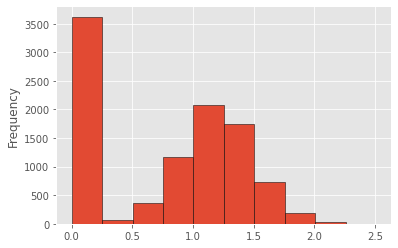

In [ ]:
#A variável Balance será divida por 1000000 para ficar na escola de 0 a 2,5
df_treino['Balance'] = df_treino['Balance']/100000
df_treino['Balance'].plot(kind = 'hist',edgecolor = 'black');

In [ ]:
df_treino.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_NumProd2+
0,0.62,42,2,0.00,1,1,1.01,1,0,0,0,0
1,0.61,41,1,0.84,0,1,1.13,0,0,1,0,0
2,0.50,42,8,1.60,1,0,1.14,1,0,0,0,1
3,0.70,39,1,0.00,0,0,0.94,0,0,0,0,1
4,0.85,43,2,1.26,1,1,0.79,0,0,1,0,0


In [ ]:
df_treino.corr()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_NumProd2+
CreditScore,1.00,-0.00,0.00,0.01,-0.01,0.03,-0.00,-0.03,0.01,0.00,-0.00,0.01
Age,-0.00,1.00,-0.01,0.03,-0.01,0.09,-0.01,0.29,0.05,-0.00,-0.03,-0.07
Tenure,0.00,-0.01,1.00,-0.01,0.02,-0.03,0.01,-0.01,-0.00,0.00,0.01,0.01
Balance,0.01,0.03,-0.01,1.00,-0.01,-0.01,0.01,0.12,0.40,-0.13,0.01,-0.36
HasCrCard,-0.01,-0.01,0.02,-0.01,1.00,-0.01,-0.01,-0.01,0.01,-0.01,0.01,0.00
IsActiveMember,0.03,0.09,-0.03,-0.01,-0.01,1.00,-0.01,-0.16,-0.02,0.02,0.02,0.02
EstimatedSalary,-0.00,-0.01,0.01,0.01,-0.01,-0.01,1.00,0.01,0.01,-0.01,-0.01,0.01
Exited,-0.03,0.29,-0.01,0.12,-0.01,-0.16,0.01,1.00,0.17,-0.05,-0.11,-0.19
Geography_Germany,0.01,0.05,-0.00,0.40,0.01,-0.02,0.01,0.17,1.00,-0.33,-0.02,-0.03
Geography_Spain,0.00,-0.00,0.00,-0.13,-0.01,0.02,-0.01,-0.05,-0.33,1.00,0.02,0.02


# Machine Learning. com X e y dividido será feito a divisão entre treino e teste, e o y dividido terá proporção de 0 e 1 igual a variavel Exited original
# Será utilizado o pacote LazyClassifier para rodar vários modelos rapidamente e com base nas metrícas de acurácia e F1 score será escolhido 3 modelos para tunagem de tunagem de hiperparâmetros, e combinação desses 3 modelos tunados, e será selecionado o melhor modelo 

In [ ]:
#Dividindo X e y

X = df_treino.drop('Exited', axis = 1)
y = df_treino[['Exited']]

In [ ]:
X

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_NumProd2+
0,0.62,42,2,0.00,1,1,1.01,0,0,0,0
1,0.61,41,1,0.84,0,1,1.13,0,1,0,0
2,0.50,42,8,1.60,1,0,1.14,0,0,0,1
3,0.70,39,1,0.00,0,0,0.94,0,0,0,1
4,0.85,43,2,1.26,1,1,0.79,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.77,39,5,0.00,1,0,0.96,0,0,1,1
9996,0.52,35,10,0.57,1,1,1.02,0,0,1,0
9997,0.71,36,7,0.00,0,1,0.42,0,0,0,0
9998,0.77,42,3,0.75,1,0,0.93,1,0,1,1


In [ ]:
y

,Exited
0,1
1,0
2,1
3,0
4,0
...,...
9995,0
9996,0
9997,1
9998,1


In [ ]:
#Dividindo X e y original em treino e teste. O argumento stratify será usado pois a variável Exited está um pouco desbalanceada 

X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size=0.3,
                                     random_state=42,stratify=y)

## LazyClassifier

In [ ]:
pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyClassifier

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.71,0.72,0.72,0.74,0.04
XGBClassifier,0.84,0.70,0.70,0.83,0.60
LGBMClassifier,0.85,0.69,0.69,0.83,0.22
AdaBoostClassifier,0.84,0.68,0.68,0.83,0.38
RandomForestClassifier,0.85,0.68,0.68,0.83,0.99
PassiveAggressiveClassifier,0.74,0.67,0.67,0.75,0.05
BaggingClassifier,0.83,0.66,0.66,0.81,0.26
ExtraTreesClassifier,0.83,0.66,0.66,0.81,0.71
DecisionTreeClassifier,0.77,0.65,0.65,0.77,0.09


## Floresta aleatória 

In [ ]:
# Configuração da Validação
kf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10)

In [ ]:
modelo=RandomForestClassifier()
parametros = {'n_estimators' :np.arange(1,200,1),
              'criterion':['gini', 'entropy'],
              'max_features': ['sqrt', 'auto', 'log2'],
              'max_depth' : np.arange(1,200,1)
                 }

random= RandomizedSearchCV(modelo, param_distributions = parametros,scoring="accuracy", cv = kf,
                                n_iter = 2, verbose = 1, n_jobs = -1)
random.fit(X_train,y_train)
random.best_score_
random.best_estimator_

Fitting 100 folds for each of 2 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.9min finished


RandomForestClassifier(max_depth=194, max_features='sqrt', n_estimators=150)

In [ ]:
#Acuracia da Floresta aleatória 
best_random=random.best_estimator_
best_random.score(X_test,y_test)

0.845

In [ ]:
#F1 score da Floresta aleatória 
f1_random= f1_score(y_test,random.predict(X_test))
print(f1_random)

0.5047923322683706


## AdaBoostClassifier

In [ ]:
modelo=AdaBoostClassifier(base_estimator=RandomForestClassifier())
parametros = {'n_estimators' :np.arange(1,200,1),
              'learning_rate':np.arange(0.1,1.5,0.1)
                 }

ada= RandomizedSearchCV(modelo, param_distributions = parametros,scoring="accuracy", cv = kf,
                                n_iter = 2, verbose = 1, n_jobs = -1)
ada.fit(X_train,y_train)
ada.best_score_
ada.best_estimator_

Fitting 100 folds for each of 2 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.9min finished


AdaBoostClassifier(base_estimator=RandomForestClassifier(),
                   learning_rate=1.3000000000000003, n_estimators=157)

In [ ]:
#Acuracia do AdaBoostClassifier 
best_ada=ada.best_estimator_
best_ada.score(X_test,y_test)

0.8476666666666667

In [ ]:
#F1 score do AdaBoostClassifier
f1_ada= f1_score(y_test,ada.predict(X_test))
print(f1_ada)

0.49945235487404166


## LGBMClassifier

In [ ]:
modelo=lgb.LGBMClassifier()
parametros = {'num_leaves ' :np.arange(1,200,1),
                 }

lgbm= RandomizedSearchCV(modelo, param_distributions = parametros,scoring="accuracy", cv = kf,
                                n_iter = 5, verbose = 1, n_jobs = -1)
lgbm.fit(X_train,y_train)
lgbm.best_score_
lgbm.best_estimator_

Fitting 100 folds for each of 5 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


LGBMClassifier(num_leaves =178)

In [ ]:
#Acuracia do LGBMClassifier
best_lgbm=lgbm.best_estimator_
accuracy_score(y_test,lgbm.predict(X_test))

0.8476666666666667

In [ ]:
#F1 score do LGBMClassifier
f1_lgbm= f1_score(y_test,lgbm.predict(X_test))
print(f1_lgbm)

0.5322415557830091


## Combinação de modelos

In [ ]:
#modelos
random_escolhido = random.best_estimator_
ada_escolhido= ada.best_estimator_
lgbm_escolhido = lgbm.best_estimator_

In [ ]:
#Combinação hard
modelos = [('floresta_aleatória', random_escolhido),('AdaBoostClassifier', ada_escolhido),('kLGBMClassifiernn', lgbm_escolhido)]

modelo_hard = VotingClassifier(modelos, voting = 'hard')
modelo_hard.fit(X_train,y_train)


VotingClassifier(estimators=[('floresta_aleatória',
                              RandomForestClassifier(max_depth=194,
                                                     max_features='sqrt',
                                                     n_estimators=150)),
                             ('AdaBoostClassifier',
                              AdaBoostClassifier(base_estimator=RandomForestClassifier(),
                                                 learning_rate=1.3000000000000003,
                                                 n_estimators=157)),
                             ('kLGBMClassifiernn',
                              LGBMClassifier(num_leaves =178))])

In [ ]:
#Acuracia da combinação hard
accuracy_score(y_test,modelo_hard.predict(X_test))

0.849

In [ ]:
#F1 score da combinação hard
f1_hard= f1_score(y_test,modelo_hard.predict(X_test))
print(f1_hard)

0.5063829787234042


In [ ]:
#Combinação soft
modelos = [('floresta_aleatória', random_escolhido),('AdaBoostClassifier', ada_escolhido),('kLGBMClassifiernn', lgbm_escolhido)]

modelo_soft = VotingClassifier(modelos, voting = 'soft')
modelo_soft.fit(X_train,y_train)

VotingClassifier(estimators=[('floresta_aleatória',
                              RandomForestClassifier(max_depth=194,
                                                     max_features='sqrt',
                                                     n_estimators=150)),
                             ('AdaBoostClassifier',
                              AdaBoostClassifier(base_estimator=RandomForestClassifier(),
                                                 learning_rate=1.3000000000000003,
                                                 n_estimators=157)),
                             ('kLGBMClassifiernn',
                              LGBMClassifier(num_leaves =178))],
                 voting='soft')

In [ ]:
#Acuracia da combinação soft
accuracy_score(y_test,modelo_soft.predict(X_test))

0.848

In [ ]:
#F1 score da combinação soft
f1_soft= f1_score(y_test,modelo_soft.predict(X_test))
print(f1_soft)

0.5210084033613447


## Fazendo previsão no cojunto de teste

In [ ]:
lgbm_escolhido = lgbm.best_estimator_
print(lgbm_escolhido)

LGBMClassifier(num_leaves =178)


#Será realizado o pré processamento que foi realizado no cojunto de treino no conjunto de validação
#O melhor modelo foi o LGBMClassifier que apresentou acurácia semelhante aos outros e um F1 score um pouco maior, ele será utilizado para previsão final

In [ ]:
# dropando variaveis sem interesse
df_teste.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)
df_teste

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,565,France,Male,31,1,0.00,1,0,1,20443.08
1,569,France,Male,34,4,0.00,1,0,1,4045.90
2,669,France,Female,20,7,0.00,2,1,0,128838.67
3,694,France,Male,39,4,173255.48,1,1,1,81293.10
4,504,Spain,Male,28,10,109291.36,1,1,1,187593.15
...,...,...,...,...,...,...,...,...,...,...
995,531,France,Female,34,10,118306.79,1,1,0,26493.05
996,575,Germany,Male,49,2,136822.70,1,1,0,2487.74
997,520,France,Female,74,4,0.00,1,0,0,26742.92
998,675,Spain,Male,23,8,0.00,2,0,0,162342.21


In [ ]:
#na variavel de produtos como  3 e 4 somam em torno de 3% de clientes, eles serão somados ao número de clientes com  2 produtos, 
#e essa variavel transformada terá número de clientes com 1 produtos e número de clientes que tem mais de 2 produtos
def fun(x):
    if x == 1:
        return 'NumProd1'
    else:
        return 'NumProd2+'

df_teste['NumOfProducts'] = df_teste['NumOfProducts'].apply(fun)

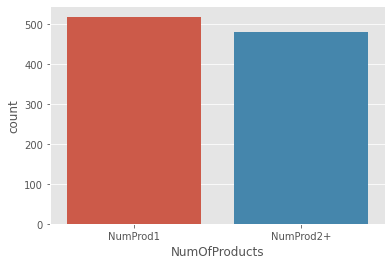

In [ ]:
sns.countplot(x=df_teste["NumOfProducts"])

In [ ]:
#A variável Geography ,Gender, NumOfProducts serão dummificadas 
variaveis = ["Geography", "Gender","NumOfProducts"]

df_teste = pd.get_dummies(df_teste, columns = variaveis, drop_first = True)

df_teste.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_NumProd2+
0,565,31,1,0.00,0,1,20443.08,0,0,1,0
1,569,34,4,0.00,0,1,4045.90,0,0,1,0
2,669,20,7,0.00,1,0,128838.67,0,0,0,1
3,694,39,4,173255.48,1,1,81293.10,0,0,1,0
4,504,28,10,109291.36,1,1,187593.15,0,1,1,0


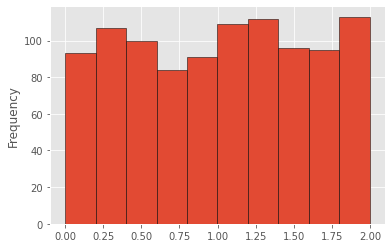

In [ ]:
#A variável EstimatedSalary será divida por 100 mil para ficar na escola de 0 a 2
df_teste['EstimatedSalary'] = df_teste['EstimatedSalary']/100000
df_teste['EstimatedSalary'].plot(kind = 'hist',edgecolor = 'black');

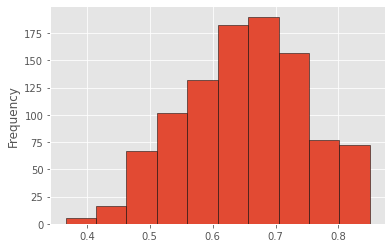

In [ ]:
#A variável CreditScore será divida por 1000 para ficar na escola de 0 a 1
df_teste['CreditScore'] = df_teste['CreditScore']/1000
df_teste['CreditScore'].plot(kind = 'hist',edgecolor = 'black');

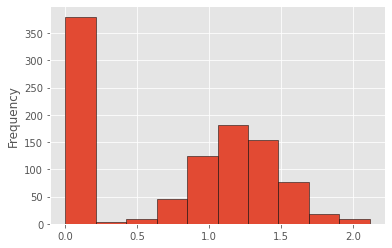

In [ ]:
#A variável Balance será divida por 1000000 para ficar na escola de 0 a 2,5
df_teste['Balance'] = df_teste['Balance']/100000
df_teste['Balance'].plot(kind = 'hist',edgecolor = 'black');

In [ ]:
df_teste.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_NumProd2+
0,0.56,31,1,0.00,0,1,0.20,0,0,1,0
1,0.57,34,4,0.00,0,1,0.04,0,0,1,0
2,0.67,20,7,0.00,1,0,1.29,0,0,0,1
3,0.69,39,4,1.73,1,1,0.81,0,0,1,0
4,0.50,28,10,1.09,1,1,1.88,0,1,1,0


In [ ]:
#Ajustando X para previsão final

X_final = df_teste

In [ ]:
#Previsão
previsao=lgbm_escolhido.predict(X_final)

In [ ]:
subm = pd.DataFrame()
subm['predictedValues'] = previsao

In [ ]:
subm.to_csv('previsão_Leon.csv', index = False)